In [1]:
from numpy import *
from scipy.integrate import solve_ivp
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import os
import pandas as pd
import sys

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

AxesLabel, TickLabel = [30, 30]
plt.rcParams.update({
    'font.size' : TickLabel,                   # Set font size to 11pt
    'axes.labelsize': AxesLabel,               # -> axis labels
    'legend.fontsize': AxesLabel,              # -> legends
    'xtick.labelsize': TickLabel,              # -> x-axis tick labels
    'ytick.labelsize': TickLabel,              # -> y-axis tick labels
})


In [2]:
# Laplace equation for a sessile drop
def LaplaceEqn(t, y, Bo, KappaT):
    Phi = y[0]
    r = y[1]
    z = y[2]

    f0 = Bo*z + KappaT #- sin(Phi)/r
    f1 = cos(Phi)
    f2 = sin(Phi)

    return array([f0, f1, f2])

# stop integration when Phi = pi
def event(t, y, Bo, KappaT):
    return y[0] - 1.001*pi

# calculate the volume of the drop given by (R, Z)
def volume(R, Z):
    return -pi*trapz(R**2, Z)

# calculate the volume of the drop given by (R, Z)
def surface(R, Z, S):
    return 2*pi*trapz(R, S)

# calculate the center of mass of the drop given by (R, Z)
def centerOfMass(R, Z):
    return trapz((R**2)*Z, Z)/trapz(R**2, Z)

# main funtion to get the drop shape
def getDrop(Bo, KappaT):
  # Initial conditions
  Phi0, r0, z0 = 0.0, 1e-50, 0.0
  y0 = array([Phi0, r0, z0])
  y0.reshape(3,)

  # parameterizatio is done using the arc length s
  s0, sMax, ds = 0.0, 5*pi, 1e-6
  
  event.terminal = True
  return solve_ivp(LaplaceEqn, [s0, sMax], y0, args=(Bo, KappaT), t_eval=arange(s0, sMax, ds), events=event, rtol=1e-10, atol=1e-16)


In [3]:
def CorrectDrop(Bo, CountMax, lr, KappaT):
      Error, VolError = [], 1.0
      count = 0
      while (abs(VolError) > 1.0e-10 and count < CountMax):
        print('------------------------------------')
        count += 1
        sol = getDrop(Bo, KappaT)
        S, Phi, r, z = sol.t, sol.y[0], sol.y[1], sol.y[2]
        # coordinate transformation to have drop straight up
        Z = -z+z[-1]
        R = r
        # join a straight line from the last point to the origin
        Z = append(Z, 0.0)
        R = append(R, 0.0)
        S = append(S, S[-1]+r[-1])
        r = append(r, 0.0)
        z = append(z, z[-1])
        Phi = append(Phi, pi)

        Vol = volume(R, Z)
        VolError = Vol - pi
        print('Volume = %4.3e and VolError = %4.3e' % (Vol, VolError))

        # use gradient descent to find the updated KappaT
        if KappaT < 1:
          KappaT = KappaT*(1.0 + lr*VolError)
        else:
          KappaT = KappaT + lr*VolError
        
        print('Done: Iteration = %d, Next KappaT = %5.4e' % (count, KappaT))
        Error.append(VolError)
        KappaTNew = KappaT

      print('------------------------------------')
      
      return R, Z, S, Phi, r, z, KappaTNew, Error

In [4]:
def gettingFacets(L0, InitConditionFile):
    import subprocess as sp
    exe = ["./InitialCondition2D", str(L0), InitConditionFile]
    p = sp.Popen(exe, stdout=sp.PIPE, stderr=sp.PIPE)
    stdout, stderr = p.communicate()
    temp1 = stderr.decode("utf-8")
    temp2 = temp1.split("\n")
    segs = []
    skip = False
    if (len(temp2) > 1e2):
        for n1 in range(len(temp2)):
            temp3 = temp2[n1].split(" ")
            if temp3 == ['']:
                skip = False
                pass
            else:
                if not skip:
                    temp4 = temp2[n1+1].split(" ")
                    r1, z1 = array([float(temp3[1]), float(temp3[0])])
                    r2, z2 = array([float(temp4[1]), float(temp4[0])])
                    segs.append(((r1, z1),(r2,z2)))
                    skip = True
    return segs

In [5]:
def Plotting(R, Z, S, Phi, r, z, filename, Bo, KappaT, Zcm, InterfaceBas, TestWithBasilisk):
    S = S/pi

    fig, AX = plt.subplots(2, 2)
    fig.patch.set_facecolor('white')
    fig.set_size_inches(20, 15)
    ax1, ax2, ax3, ax4 = AX.flatten()

    
    ax1.plot(R, Z, 'r-', linewidth=4.0)
    ax1.plot(-R, Z, 'r-', linewidth=4.0)
    if TestWithBasilisk:
        line_segments = LineCollection(InterfaceBas, linewidths=4, colors='#1a9641', linestyle='solid')
        ax1.add_collection(line_segments)

    ax1.plot(0, Zcm, 'bo', markersize=15.0)
    ax1.set_xlabel(r'$\mathcal{R}/R_0$')
    ax1.set_ylabel(r'$\mathcal{Z}/R_0$')
    if Bo<125:
        ax1.set_aspect('equal')
    else:
        ax1.set_box_aspect(1)
    ax1.set_xlim(-1.1*R.max(), 1.1*R.max())
    ax1.set_ylim(0.0, 1.05*Z.max())

    ax2.plot(S, Phi/pi, 'b-', linewidth=4.0)
    ax2.set_xlabel(r'$s/\left(\pi R_0\right)$')
    ax2.set_ylabel(r'$\phi/\pi$')
    ax2.set_box_aspect(1)
    ax2.set_xlim(0.0, S.max())
    ax2.set_ylim(0.0, 1.05)

    ax3.plot(S, r, 'k-')
    ax3.set_xlabel(r'$s/\left(\pi R_0\right)$')
    ax3.set_ylabel(r'$r/R_0$')
    ax3.set_box_aspect(1)
    ax3.set_xlim(0.0, S.max())
    ax3.set_ylim(0.0, 1.05*r.max())

    ax4.plot(S, z, 'k-')
    ax4.set_xlabel(r'$s/\left(\pi R_0\right)$')
    ax4.set_ylabel(r'$z/R_0$')
    ax4.set_box_aspect(1)
    ax4.set_xlim(0.0, S.max())
    ax4.set_ylim(0.0, 1.05*z.max())
    # set figure title
    l1, b1, w1, h1 = ax1.get_position().bounds
    l2, b2, w2, h2 = ax2.get_position().bounds

    L = max(b1+h1, b2+h2)
    # set title position
    fig.text(0.5, L+0.025, r'$Bo = %5.4e$, $\kappa_TR_0 = %5.4e$' % (Bo, KappaT), fontsize=AxesLabel, ha='center')

    plt.savefig(filename, bbox_inches='tight')
    plt.show()

Initial guess for KappaT =  1.4738400842449897
------------------------------------
Volume = 8.774e-01 and VolError = -2.264e+00
Done: Iteration = 1, Next KappaT = 9.0778e-01
------------------------------------
Volume = 2.521e+00 and VolError = -6.201e-01
Done: Iteration = 2, Next KappaT = 7.6705e-01
------------------------------------
Volume = 3.474e+00 and VolError = 3.325e-01
Done: Iteration = 3, Next KappaT = 8.3081e-01
------------------------------------
Volume = 2.993e+00 and VolError = -1.482e-01
Done: Iteration = 4, Next KappaT = 8.0003e-01
------------------------------------
Volume = 3.214e+00 and VolError = 7.231e-02
Done: Iteration = 5, Next KappaT = 8.1449e-01
------------------------------------
Volume = 3.108e+00 and VolError = -3.383e-02
Done: Iteration = 6, Next KappaT = 8.0760e-01
------------------------------------
Volume = 3.158e+00 and VolError = 1.615e-02
Done: Iteration = 7, Next KappaT = 8.1086e-01
------------------------------------
Volume = 3.134e+00 and 

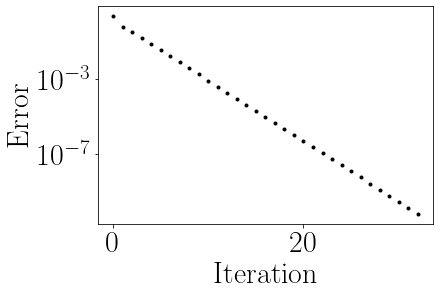

------------------------------------
(3V)(4pi)^{-1} = 7.5000e-01
Perimeter = 2.7651e+00
Surface Area = 1.0707e+01
KappaT = 8.0981e-01, Bo = 1.0000e+00, H = 1.348, Zcm = 0.596, W = 1.012, Rw = 0.522
<------------------------------------>
Doing Basilisk now for Bo = 1.0000e+00
Done with Basilisk for Bo = 1.0000e+00


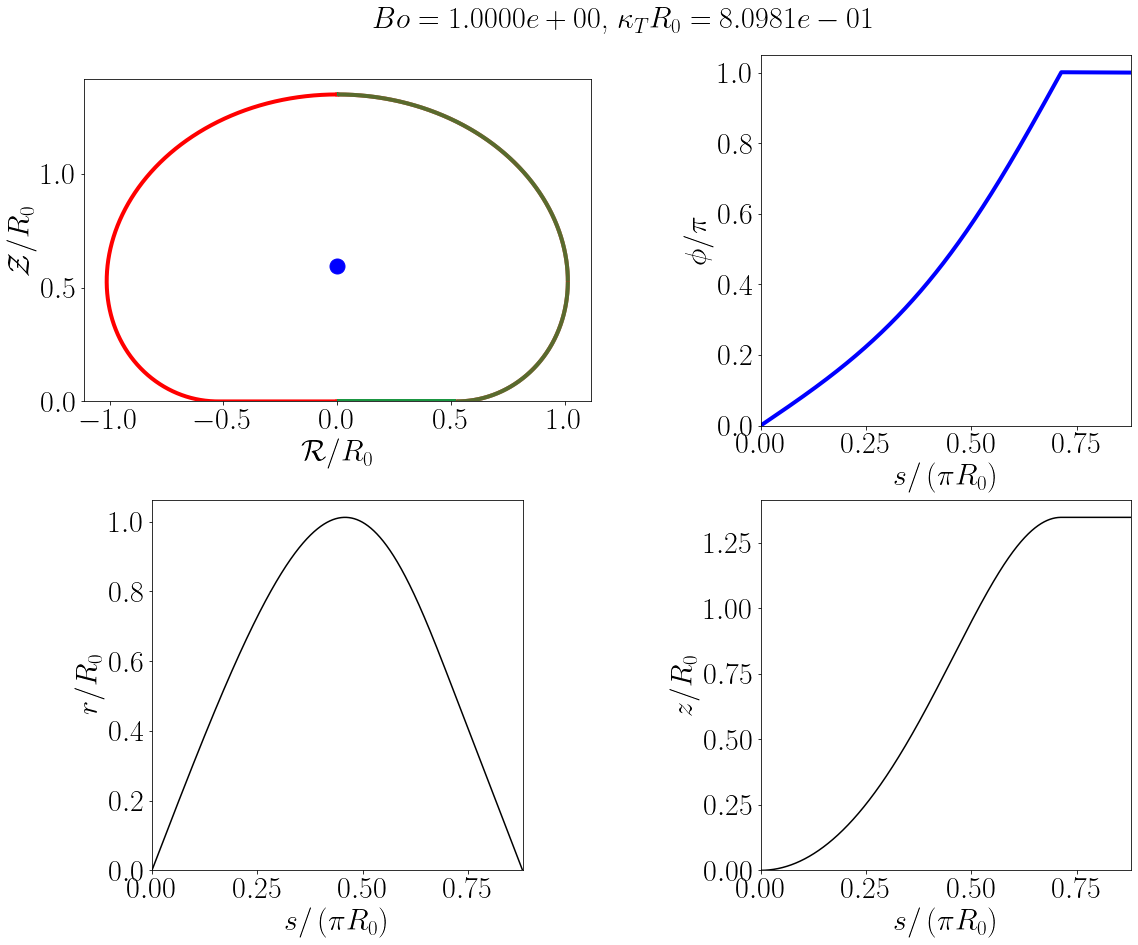

Initial guess for KappaT =  1.0338891758759068
------------------------------------
Volume = 1.246e+00 and VolError = -1.895e+00
Done: Iteration = 1, Next KappaT = 5.6003e-01
------------------------------------
Volume = 3.153e+00 and VolError = 1.139e-02
Done: Iteration = 2, Next KappaT = 5.6163e-01
------------------------------------
Volume = 3.141e+00 and VolError = -3.026e-04
Done: Iteration = 3, Next KappaT = 5.6158e-01
------------------------------------
Volume = 3.142e+00 and VolError = 8.131e-06
Done: Iteration = 4, Next KappaT = 5.6159e-01
------------------------------------
Volume = 3.142e+00 and VolError = -2.205e-07
Done: Iteration = 5, Next KappaT = 5.6159e-01
------------------------------------
Volume = 3.142e+00 and VolError = 6.134e-09
Done: Iteration = 6, Next KappaT = 5.6159e-01
------------------------------------
Volume = 3.142e+00 and VolError = -1.706e-10
Done: Iteration = 7, Next KappaT = 5.6159e-01
------------------------------------
Volume = 3.142e+00 and 

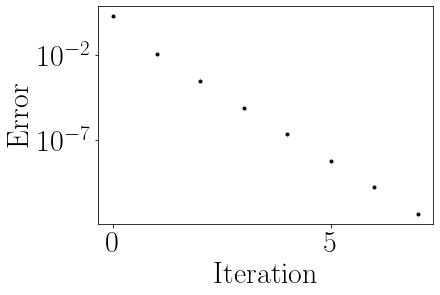

------------------------------------
(3V)(4pi)^{-1} = 7.5000e-01
Perimeter = 2.7848e+00
Surface Area = 1.1336e+01
KappaT = 5.6159e-01, Bo = 2.2500e+00, H = 1.107, Zcm = 0.472, W = 1.104, Rw = 0.754
<------------------------------------>
Doing Basilisk now for Bo = 2.2500e+00
Done with Basilisk for Bo = 2.2500e+00


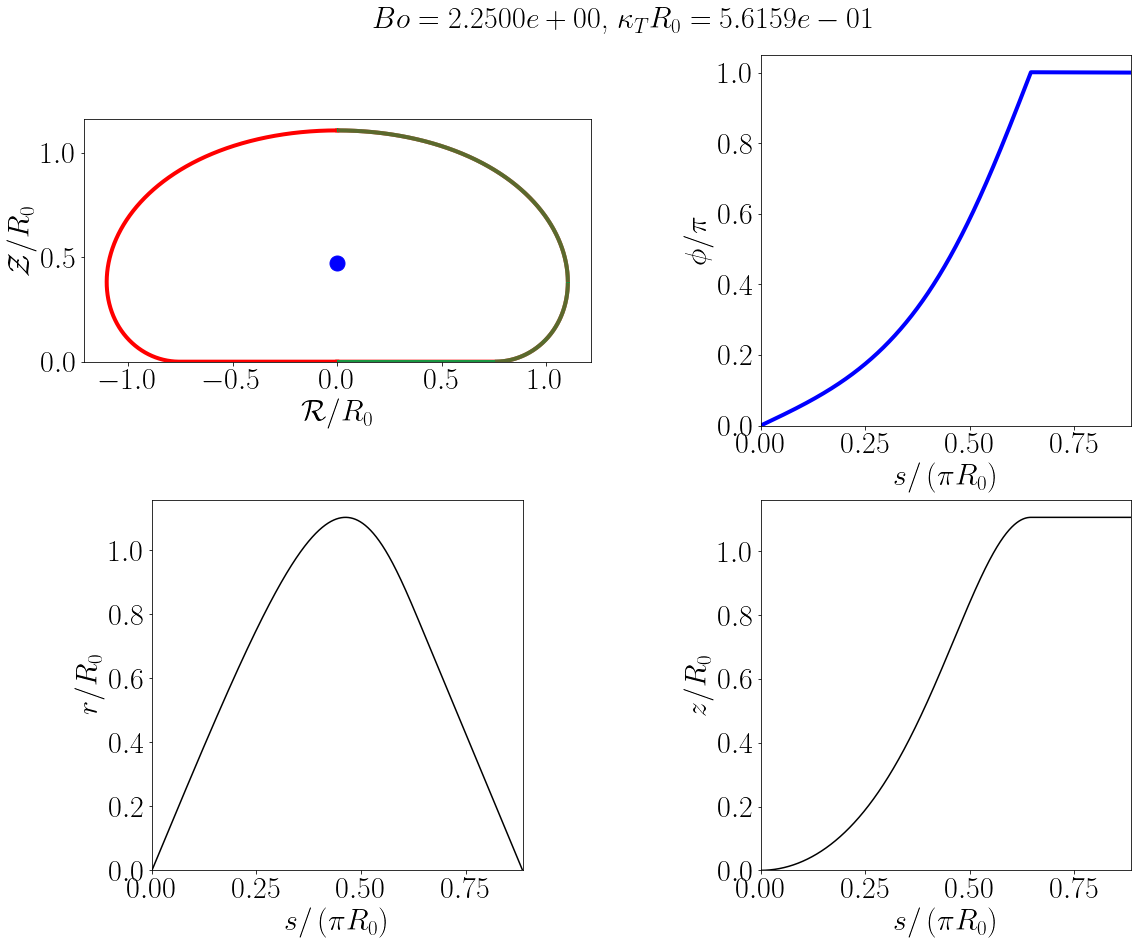

In [6]:
# Learning rate for the gradient descent algorithm and the maximum number of iterations, whether to plot the results, whether to plot error decay from the gradient descent, and the domain length for Basilisk code
lr, CountMax, Plot, PlotError, L0, TestWithBasilisk = 0.25, 500, True, True, 8.0, True
# TestWithBasilisk True needs a compiled Basilisk code in the same folder called InitialCondition.c. If you do not have this code, set TestWithBasilisk to False.

# Bond number is the input parameter. Use an array here to loop over multiple Bond numbers if needed. 
BondNumbers = array([1e0, 2.25]) #array([1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3])

KappaTlist = zeros_like(BondNumbers)
Bond = zeros_like(BondNumbers)
Height = zeros_like(BondNumbers)
Zcm = zeros_like(BondNumbers)
Width = zeros_like(BondNumbers)
Rfoot = zeros_like(BondNumbers)
Perimeter = zeros_like(BondNumbers)
SurfaceArea = zeros_like(BondNumbers)

folder='TestingImages_2D'
if not os.path.exists(folder):
    os.makedirs(folder)
TableFile='NormalizeBond.csv'
if os.path.exists(TableFile):
   df = pd.read_csv(TableFile)
   Table=True
   # df.head()
else:
   KappaGuess = 2.0
   Table=False

for Bo in BondNumbers:
  if Table:
     # find the index of the closest value to the input value
     idx = (abs(df['Bond'] - Bo)).argmin()
     # print(idx)
     KappaT = df['KappaTR0'][idx]
  else:
      KappaT = KappaGuess
  
  print("Initial guess for KappaT = ", KappaT)

  R, Z, S, Phi, r, z, KappaT, Error = CorrectDrop(Bo, CountMax, lr, KappaT)

  if PlotError:
       plt.plot(abs(array(Error)), 'k.')
       plt.xlabel('Iteration')
       plt.ylabel('Error')
       plt.yscale('log')
       plt.show()
  # Save some metrics
  Rfoot[where(BondNumbers==Bo)] = R[-2]
  # width and height of the drop
  Height[where(BondNumbers==Bo)] = Z.max()
  Width[where(BondNumbers==Bo)] = R.max()
  # center of mass
  Zcm[where(BondNumbers==Bo)] = centerOfMass(R, Z)
  # Volume of the drop
  Vol = volume(R, Z)
  Vol /= (4.0/3.0)*pi        
  # Perimeter of the drop
  Perimeter[where(BondNumbers==Bo)] = S[-1]
  # Surface area of the drop
  SurfaceArea[where(BondNumbers==Bo)] = surface(R, Z, S)
  KappaTlist[where(BondNumbers==Bo)] = KappaT

  # Print some metrics!
  print('------------------------------------')
  print('(3V)(4pi)^{-1} = %5.4e' % Vol)
  print('Perimeter = %5.4e' % Perimeter[where(BondNumbers==Bo)])
  print('Surface Area = %5.4e' % SurfaceArea[where(BondNumbers==Bo)])

  print('KappaT = %5.4e, Bo = %5.4e, H = %4.3f, Zcm = %4.3f, W = %4.3f, Rw = %4.3f' % (KappaT, Bo, float(Height[where(BondNumbers==Bo)]), float(Zcm[where(BondNumbers==Bo)]), float(Width[where(BondNumbers==Bo)]), float(Rfoot[where(BondNumbers==Bo)])))
  print('<------------------------------------>')

  if TestWithBasilisk:
     print('Doing Basilisk now for Bo = %5.4e' % Bo)
     Interface = pd.DataFrame({'x': Z, 'y': R})
     InitConditionFile='%s/InitialCondition_Bo%4.3f.dat' % (folder, Bo)
     Interface.to_csv(InitConditionFile, index=False, header=False, sep=' ')
     # Run Basilisk
     InterfaceBas = gettingFacets(L0, InitConditionFile)
     print('Done with Basilisk for Bo = %5.4e' % Bo)
  else:
     InterfaceBas = None
     
  if Plot:
    filename = '%s/Drops_Bond_%5.4f.pdf' % (folder, Bo)
    Plotting(R, Z, S, Phi, r, z, filename, Bo, KappaT, Zcm[where(BondNumbers==Bo)], InterfaceBas, TestWithBasilisk)